### Analyisis code from Forster et al., 2025, Communications Psychology

### "Pre-stimulus beta power mediates explicit and implicit perceptual biases in distinct cortical areas"

notebook loads functions for behavioral and EEG analysis and reproduces figure 1,2,3 and 4

figure 5 and 6 are based on Rscripts, which are used for regression and mediation analysis

results are published [here](https://www.nature.com/articles/s44271-025-00265-y)

currently being updated, everything runs until evoked contrasts

ToDo: - time frequency
      - source space analysis
___

    Author:  Carina Forster et al.
    Contact: forster@cbs.mpg.de
    Years:   2024/2025

___

Make sure you are in the right environment: `expecon`

## Setup 

### Imports

In [73]:
# turn off warnings for a cleaner output
import warnings

warnings.filterwarnings("ignore")

In [74]:
# plots are shown in the notebook (no new window is opened)

%matplotlib inline

### Set vars, paths, & constants

In [76]:
# Define the output for mne functions
mne.set_log_level("CRITICAL")

## Analyse 

### 1. Behavioral data analysis (Signal detection theory based)

In [80]:
from expecon_ms.behav import behavioural_descriptives_stats_figure2
help(behavioural_descriptives_stats_figure2)


Help on module expecon_ms.behav.behavioural_descriptives_stats_figure2 in expecon_ms.behav:

NAME
    expecon_ms.behav.behavioural_descriptives_stats_figure2 - The script contains functions to analyze and plot the behavioral data for the ExPeCoN study.

DESCRIPTION
    The ExPeCoN study investigates stimulus probabilities and the influence on perception and confidence in a
    near-threshold somatosensory detection task in two paradigms that vary in their probability environment:

    dataset 1 : stable environment, 144 trials in 5 blocks, 43 participants,
               stimulus probability is cued before blocks of 12 trials.
    dataset 2: variable environment, 120 trials in 5 blocks, 40 participants,
               stimulus probability is cued before each trial.

    Author: Carina Forster
    Contact: forster@cbs.mpg.de
    Years: 2023/2024/2025

FUNCTIONS
    bootstrap_ci_effect_size_wilcoxon(x1, x2, n_iterations=1000, alpha=0.95)
        Calculate the confidence interval.

      

### 2. Preprocessing EEG data

In [81]:
from expecon_ms.eeg.preprocessing import prepro as pp
from expecon_ms.eeg.preprocessing import ica

In [71]:
help(pp.prepro)

# preprocessing without ICA
pp.prepro(
    study=2,
    trigger="stimulus",
    l_freq=1,
    h_freq=40,
    tmin=-1,
    tmax=1,
    resample_rate=250,
    detrend=1,
    ransac=1,
    autoreject=0,
)

Help on function prepro in module expecon_ms.eeg.preprocessing.prepro:

prepro(study: 'int' = 1, trigger: 'str' = 'stimulus', l_freq: 'float' = 0.1, h_freq: 'int' = 40, tmin: 'float' = -2, tmax: 'float' = 2, resample_rate: 'float' = 250, detrend: 'int' = 1, ransac: 'int' = True, autoreject: 'int' = False)
    Preprocess EEG data using the MNE toolbox.

    As implemented in MNE, add channel locations according to the 10/10 system,
    load a specified behavioral data file (.csv) and add events as metadata to
    each epoch, inspect data for bad channels and bad epochs using RANSAC from the
    autoreject package. To ensure the same amount of channels for all subjects,
    we interpolate bad channels, after interpolating the bad channels, the data is
    epoched to the stimulus or cue trigger events and saved as an -epo.fif file.

    Args:
    ----
    study: int
        data from first or second study
        Options: 1 or 2
    trigger: str
        Specifies whether to epoch the data

FileNotFoundError: fname does not exist: "C:\Users\Carina\ExPeCoN_ms\code\expecon_ms\data\eeg\raw_concatenated_expecon2_anon\7TQ58Y_raw.fif"

In [55]:
# how many channels were interpolated?
pp.n_channels_interpolated(study=2, trigger="stimulus", l_freq=0.1)

mean channels interpolated 3.0
std of channels interpolated: nan
min channels interpolated: 3
max channels interpolated: 3


[]


FileExistsError: Destination file exists. Please use option "overwrite=True" to force overwriting.

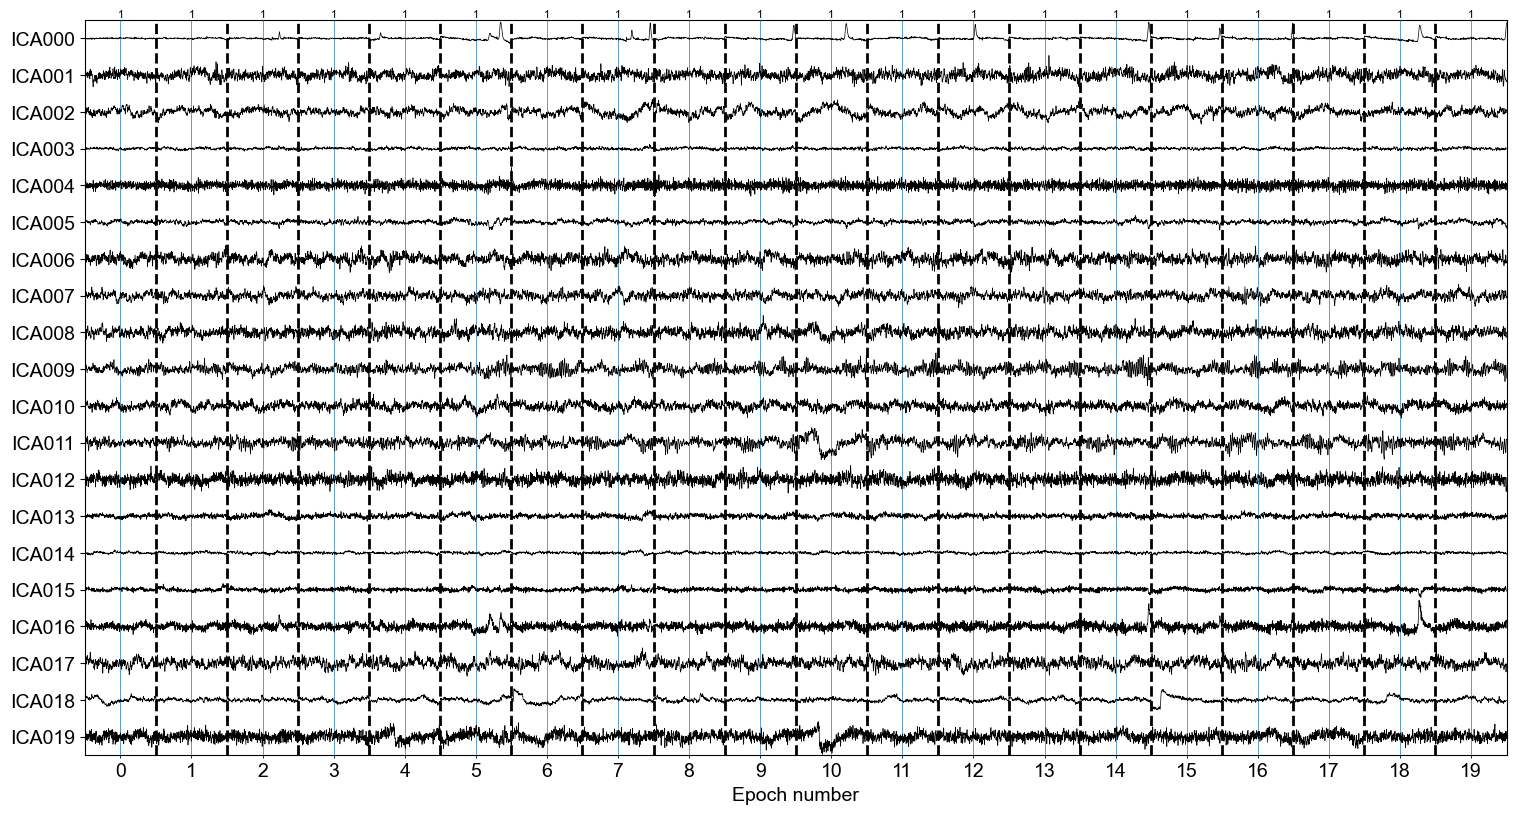

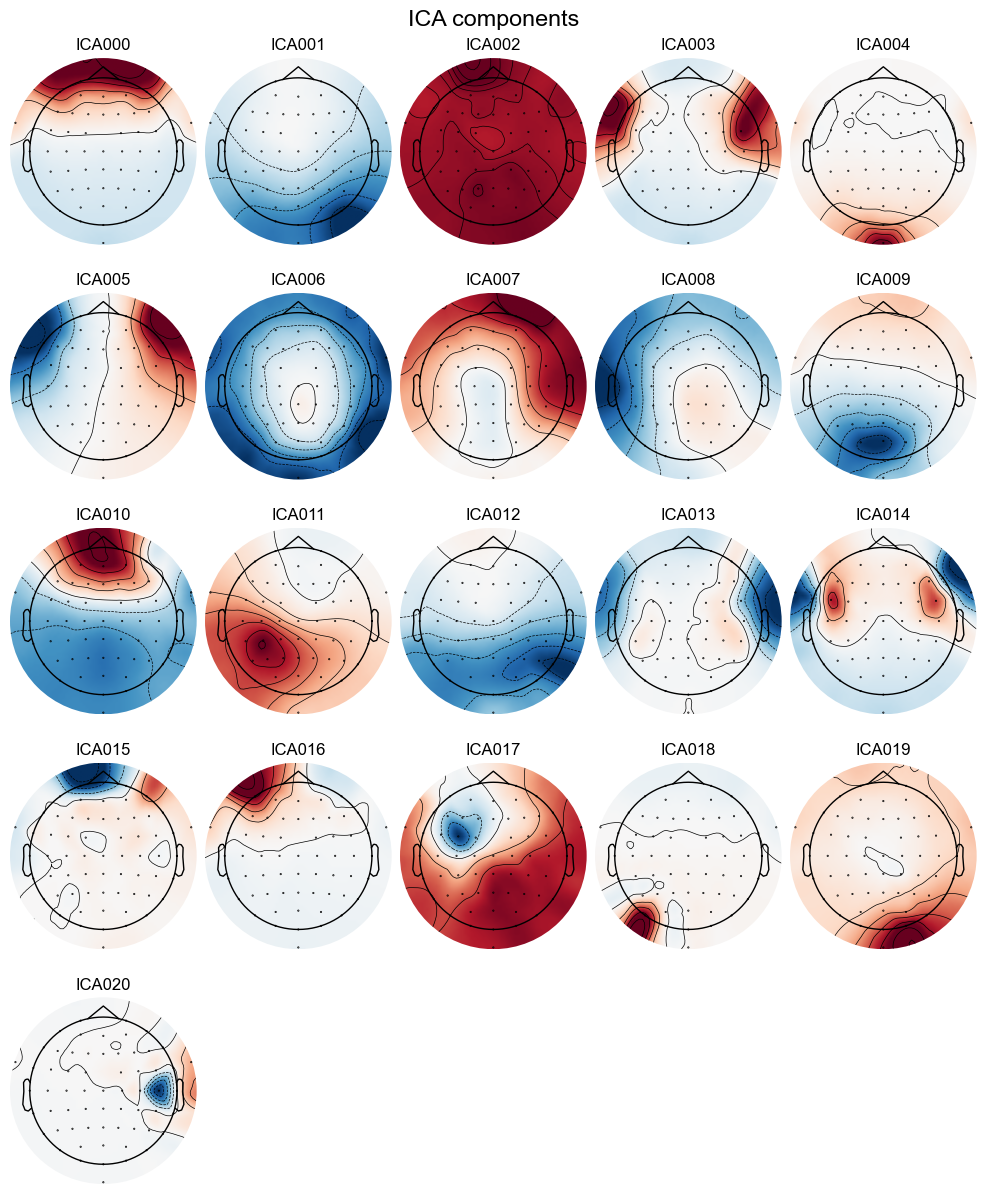

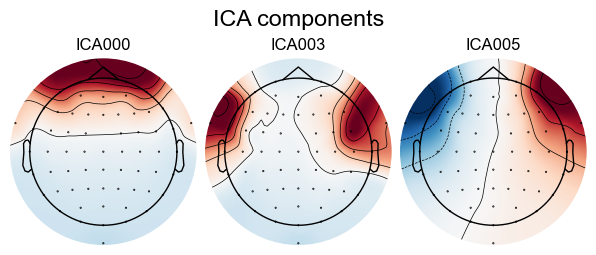

In [72]:
# run ica on clean, epoched data (recommended on 1Hz filtered data)
ica.run_ica(study=2, infomax=1, l_freq=1, save_psd=1)


# correlate with EOG and ECG and mark bad componets for rejection, apply to data you
# want to use for further analysis (0.1Hz filtered for Erps)
ica.label_ica_correlation(study=2, save_psd=1)

### 3. Evoked potentials

In [59]:
from expecon_ms.eeg.sensor import evokeds_analysis as evo

Processing participant 1/1 (ID: NGRBFS)
Removed trials based on reaction time:  5
Mean hit rate: 0.64
Blocks with hit rates > 0.9 or < 0.2:  0
Blocks with false alarm rates > 0.4: 0
Blocks with hit rates < false alarm rates: 0


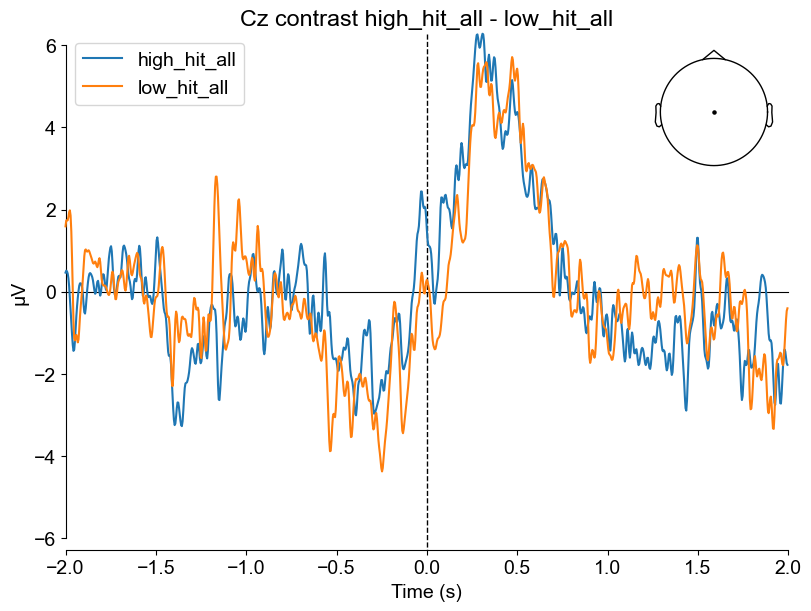

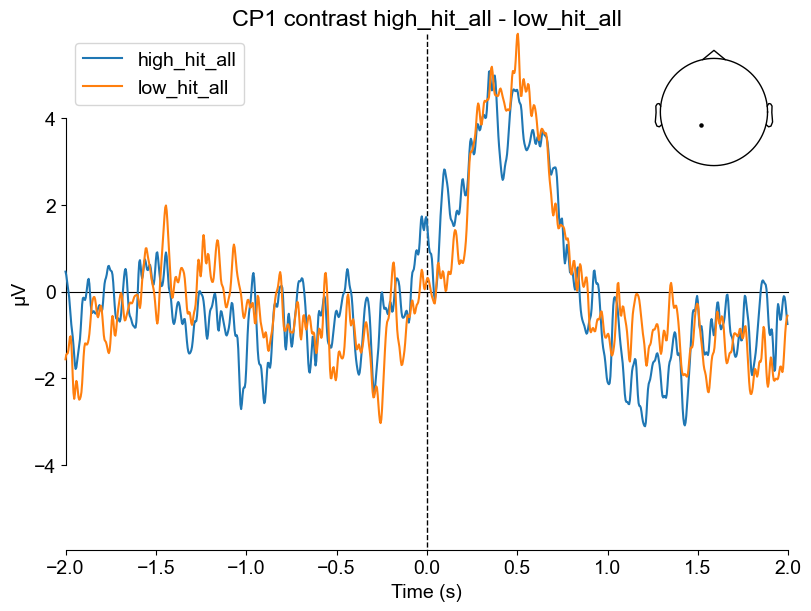

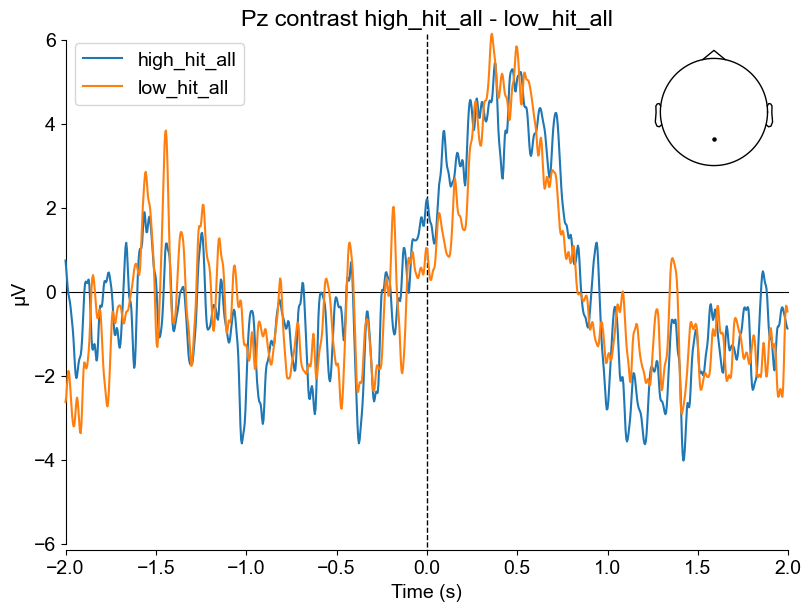

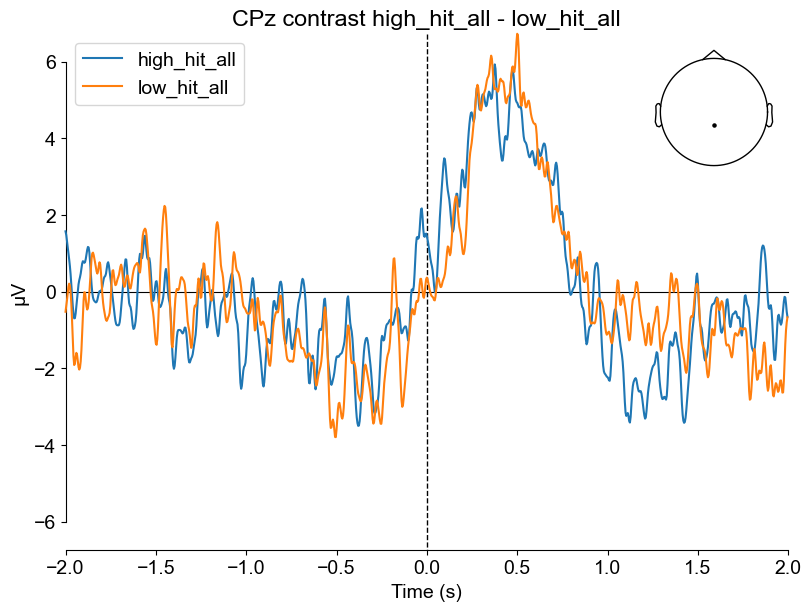

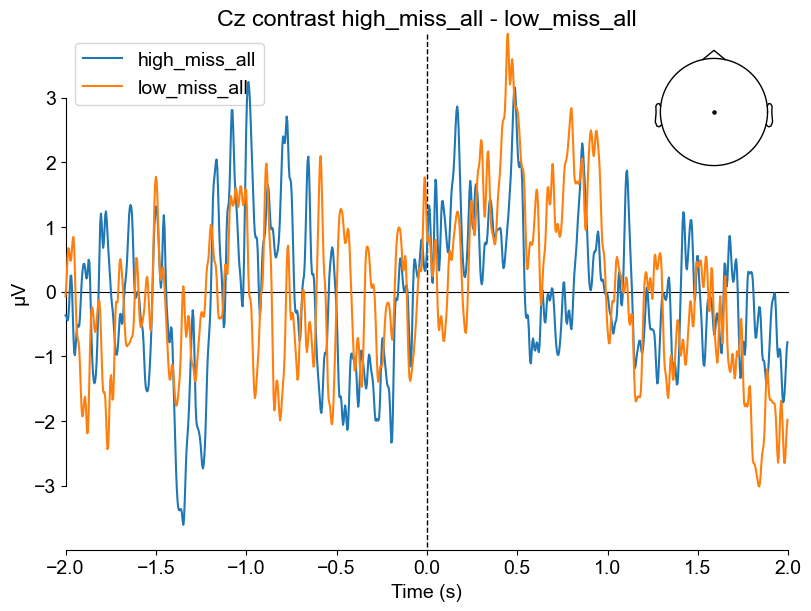

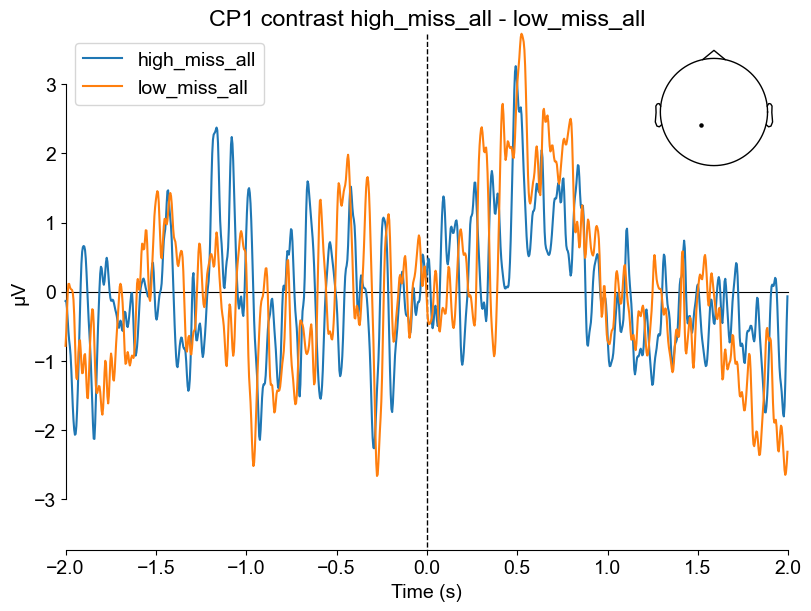

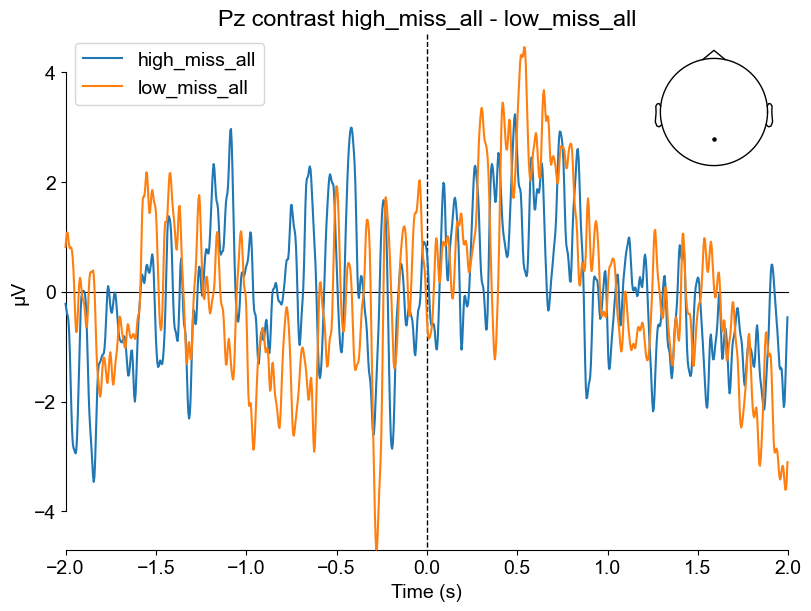

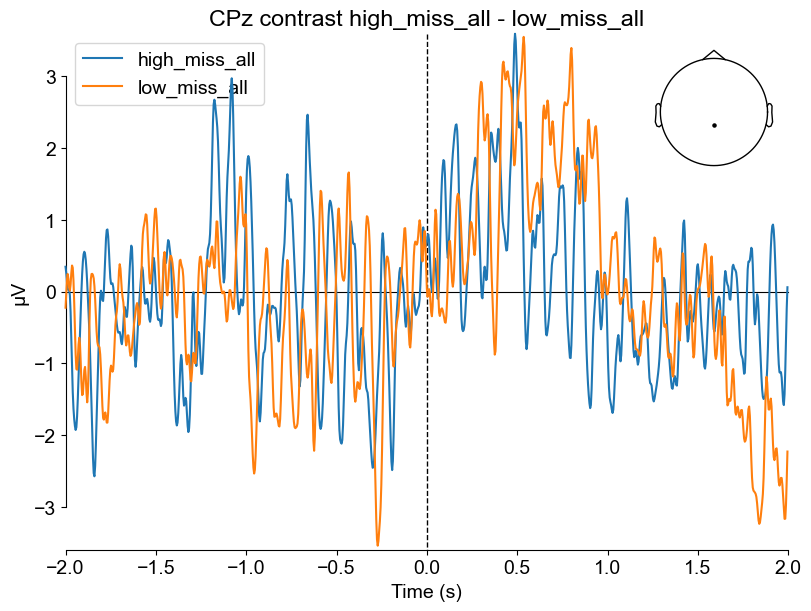

In [62]:
# compare evokeds and plot contrasts
evo.plot_CPP(study = 2, baseline = True,
             tmin = -2, tmax = 2, tmin_base = -0.3, 
             tmax_base = -0.05,
             channel_list = ['Cz', 'CP1', 'Pz', 'CPz'])

### 4. Time-frequency analysis

In [63]:
from expecon_ms.eeg.sensor import tfr_figure3 as tfr

In [64]:
# compute tfr representations for each condition
tfr.compute_tfr(
    study=2,
    cond="probability",
    tmin=-0.7,
    tmax=0,
    fmax=35,
    fmin=3,
    laplace=False,
    induced=True,
    mirror=False,
    drop_bads=True,
)

NameError: name 'participants' is not defined

#### stimulus probability contrast

In [ ]:
# load the tfr data for each condition for probability conds.
tfr_a_cond, tfr_b_cond = tfr.load_tfr_conds(
    studies=[1, 2],
    cond="probability",
    cond_a_name="high_-0.7_0_induced",
    cond_b_name="low_-0.7_0_induced",
    cond_a_names=["high_prevhit_-0.7_0_induced", "high_prevmiss_-0.7_0_induced", "high_prevcr_-0.7_0_induced"],
    cond_b_names=["low_prevhit_-0.7_0_induced", "low_prevmiss_-0.7_0_induced", "low_prevcr_-0.7_0_induced"],
)

In [ ]:
# run-cluster-based permutation tests for the conditions contrast
# and plot sign. cluster
tfr.plot_tfr_cluster_test_output(
    cond="probability",
    tfr_a_cond=tfr_a_cond,
    tfr_b_cond=tfr_b_cond,
    threed_test=False,
    cond_a_name="high_induced",
    cond_b_name="low_induced",
    channel_names=["CP4"],
)

previous response contrast

In [ ]:
# load the tfr data for each condition for prev_resp conds.
tfr_a_cond, tfr_b_cond = tfr.load_tfr_conds(
    studies=[1, 2],
    cond="prev_resp",
    cond_a_name="prevyesresp_highprob_prevstim_-0.7_0_induced",
    cond_b_name="prevnoresp_highprob_prevstim_-0.7_0_induced",
    cond_a_names=["prevyesresp_samecue_lowprob_-0.7_0_induced", "prevyesresp_samecue_highprob_-0.7_0_induced"],
    cond_b_names=["prevnoresp_samecue_lowprob_-0.7_0_induced", "prevnoresp_samecue_highprob_-0.7_0_induced"],
)

In [ ]:
# run cluster based permutation tests for the conditions contrasts
# and plot sign. cluster
tfr.plot_tfr_cluster_test_output(
    cond="prev_resp",
    tfr_a_cond=tfr_a_cond,
    tfr_b_cond=tfr_b_cond,
    threed_test=False,
    cond_a_name="prevyesresp",
    cond_b_name="prevnoresp",
    channel_names=["CP4"],
)

### 5. Source reconstruction

In [65]:
from expecon_ms.eeg.source import source_reco as src

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Carina\\ExPeCoN_ms\\code\\expecon_ms\\data\\templates\\func_label_probability_2_-700-rh.label'

In [ ]:
# run source reconstruction for each condition
src.run_source_reco(
    study=1,
    cond="prev_resp",
    mirror=False,
    dics=True,
    fmin=15,
    fmax=25,
    tmin=-0.7,
    tmax=-0.1,
    drop_bads=True,
    subtract_evokeds=True,
    plot_alignment=False,
)

In [ ]:
# plot source contrast (grand average over all participants)
# opens plots in separate windows
src.plot_grand_average_source_contrast(study=1, cond="probability", method="beamformer", save_plots=False)

In [ ]:
# run source localization for each epoch based on filter from contrast

In [ ]:
src.run_source_reco_per_trial(study=2, fmin=15, fmax=25, tmin=-0.7, tmax=-0.1, drop_bads=True)